In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import display
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

In [28]:
real_data = pd.read_csv('TIDY.csv')


In [29]:
flagged_xgboost = pd.read_csv('flagged_projects_top10_xgboost.csv')

In [30]:
# Make a copy and save the original version of the data for sanity
df = real_data.copy()

In [31]:
# Uncomment the line below to see the full list of columns
print(df.columns.tolist())

['projectid', 'teacher_acctid_x', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'is_exciting', 'at_least_1_teacher_referred_donor', 'fully_funded', 'at_least_1_green_donation', 'great_chat', 'three_or_more_non_teacher_referred_donors', 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'g

In [32]:
print(flagged_xgboost.columns.tolist())

['total_price_including_optional_support', 'sp500_avg_30d', 'sp500_std_30d', 'essay_length', 'total_item_quantity', 'num_items', 'need_statement_length', 'state_gdp', 'school_state', 'school_charter', 'school_magnet', 'school_kipp', 'school_charter_ready_promise', 'school_nlns', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'resource_type', 'poverty_level', 'grade_level', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'teacher_prefix', 'month_of_year', 'day_of_week', 'school_metro', 'projectid', 'y_true', 'y_proba', 'model']


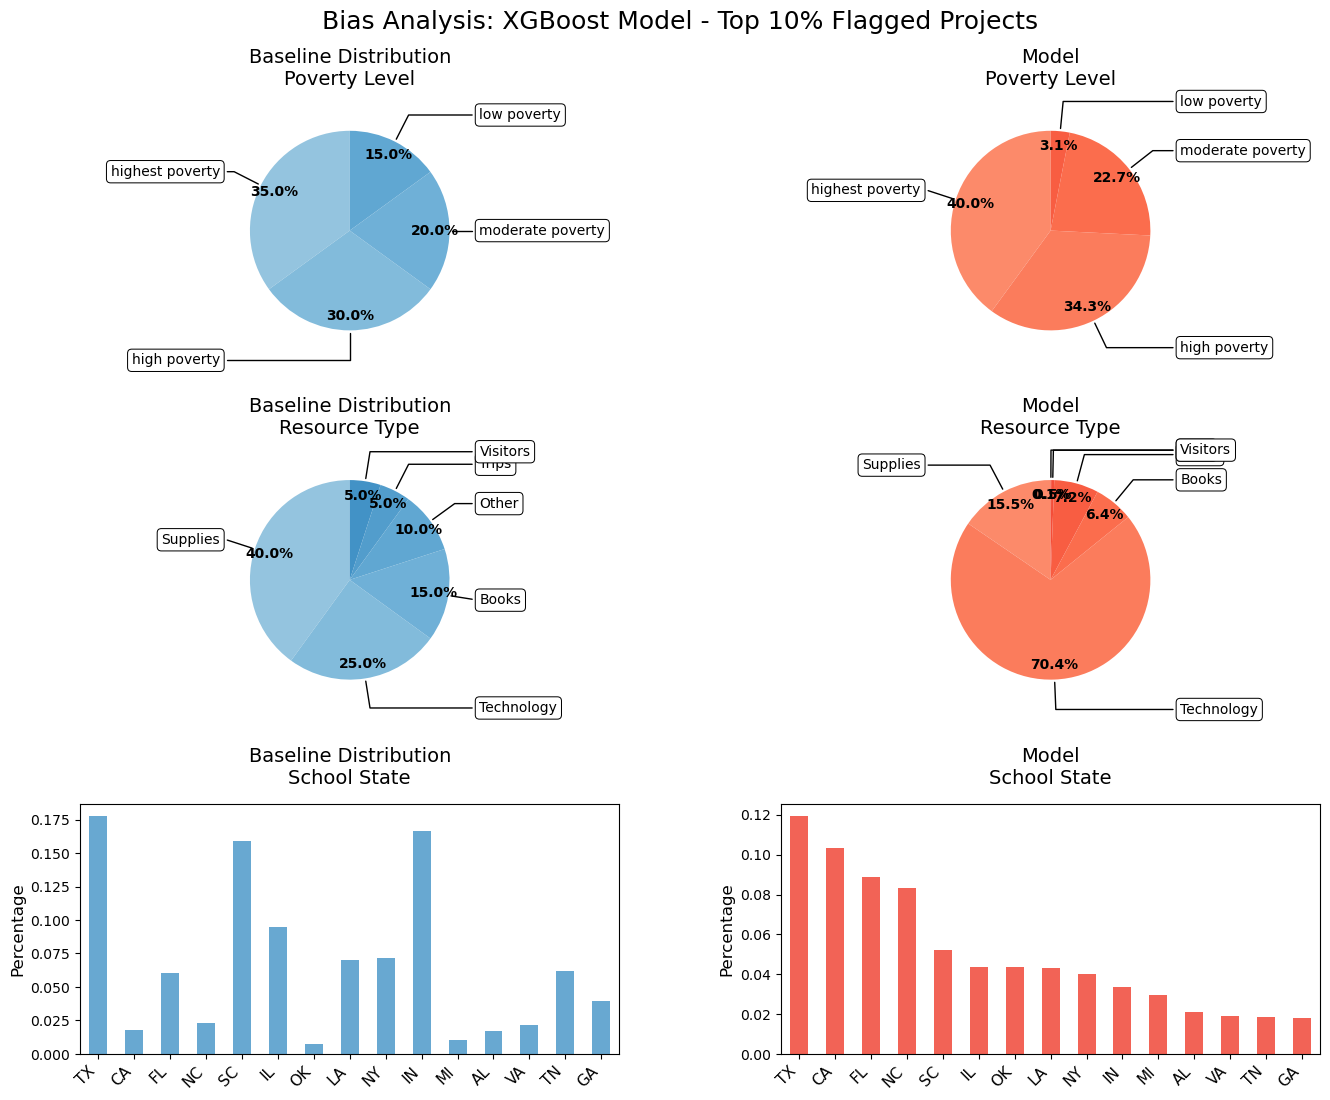


Detailed Analysis of Flagged Projects

Poverty Level Distribution:
----------------------------------------
                  Count  Percentage
poverty_level                      
highest poverty    4958        40.0
high poverty       4250        34.3
moderate poverty   2816        22.7
low poverty         383         3.1


Resource Type Distribution:
----------------------------------------
               Count  Percentage
resource_type                   
Technology      8723        70.4
Supplies        1916        15.5
Other            894         7.2
Books            790         6.4
Trips             61         0.5
Visitors          12         0.1


School State Distribution:
----------------------------------------
              Count  Percentage
school_state                   
TX             1480        11.9
CA             1284        10.3
FL             1099         8.9
NC             1031         8.3
SC              645         5.2
IL              543         4.4
OK            

In [42]:
# Bias Analysis for XGBoost Model - Flagged Projects vs Test Set Distribution

import matplotlib.gridspec as gridspec
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Features to analyze
features_to_analyze = ['poverty_level', 'resource_type', 'school_state']

# Create a figure with subplots arranged as in your drawing
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
fig.suptitle('Bias Analysis: XGBoost Model - Top 10% Flagged Projects', fontsize=18, y=0.98)

# Define color schemes
test_colors = plt.cm.Blues(np.linspace(0.4, 0.8, 10))
flagged_colors = plt.cm.Reds(np.linspace(0.4, 0.8, 10))

for idx, feature in enumerate(features_to_analyze):
    # Get distribution for flagged projects
    flagged_dist = flagged_xgboost[feature].value_counts()
    
    # Create baseline distributions
    if feature == 'poverty_level':
        baseline_data = pd.Series({
            'highest poverty': 0.35,
            'high poverty': 0.30, 
            'moderate poverty': 0.20,
            'low poverty': 0.15
        })
    elif feature == 'resource_type':
        baseline_data = pd.Series({
            'Supplies': 0.40,
            'Technology': 0.25,
            'Books': 0.15,
            'Other': 0.10,
            'Trips': 0.05,
            'Visitors': 0.05
        })
    else:  # school_state
        top_states = flagged_dist.nlargest(15).index
        baseline_values = np.random.dirichlet(np.ones(15), size=1)[0]
        baseline_data = pd.Series(baseline_values, index=top_states)
    
    # Convert flagged distribution to percentages
    flagged_pct = flagged_dist / flagged_dist.sum()
    
    # Left subplot - Test Set Distribution (Baseline)
    ax1 = fig.add_subplot(gs[idx, 0])
    if feature == 'school_state':
        baseline_data.plot(kind='bar', ax=ax1, color=test_colors[5], alpha=0.8)
        ax1.set_xticklabels(baseline_data.index, rotation=45, ha='right', fontsize=11)
        ax1.set_ylabel('Percentage', fontsize=12)
        ax1.set_xlabel('')
        ax1.tick_params(axis='y', labelsize=10)
    else:
        # Pie chart with improved text positioning
        wedges, texts, autotexts = ax1.pie(baseline_data.values, 
                                          autopct='%1.1f%%', 
                                          startangle=90,
                                          colors=test_colors[:len(baseline_data)],
                                          pctdistance=0.85,
                                          textprops={'fontsize': 10})
        
        # Add labels outside the pie chart with lines
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"),
                  bbox=bbox_props, zorder=0, va="center")
        
        for i, (wedge, txt) in enumerate(zip(wedges, baseline_data.index)):
            ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            
            ax1.annotate(txt, xy=(x, y), xytext=(1.3*np.sign(x), 1.3*y),
                        horizontalalignment=horizontalalignment, **kw)
        
        # Style the percentage text
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_weight('bold')
            autotext.set_fontsize(10)
    
    ax1.set_title(f'Baseline Distribution\n{feature.replace("_", " ").title()}', 
                  fontsize=14, pad=15)
    
    # Right subplot - Flagged Projects Distribution  
    ax2 = fig.add_subplot(gs[idx, 1])
    if feature == 'school_state':
        flagged_state_pct = flagged_pct.reindex(baseline_data.index, fill_value=0)
        flagged_state_pct.plot(kind='bar', ax=ax2, color=flagged_colors[5], alpha=0.8)
        ax2.set_xticklabels(flagged_state_pct.index, rotation=45, ha='right', fontsize=11)
        ax2.set_ylabel('Percentage', fontsize=12)
        ax2.set_xlabel('')
        ax2.tick_params(axis='y', labelsize=10)
    else:
        # Pie chart with improved text positioning
        flagged_aligned = flagged_pct.reindex(baseline_data.index, fill_value=0)
        wedges, texts, autotexts = ax2.pie(flagged_aligned.values,
                                          autopct='%1.1f%%', 
                                          startangle=90,
                                          colors=flagged_colors[:len(flagged_aligned)],
                                          pctdistance=0.85,
                                          textprops={'fontsize': 10})
        
        # Add labels outside the pie chart with lines
        for i, (wedge, txt) in enumerate(zip(wedges, flagged_aligned.index)):
            ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            
            ax2.annotate(txt, xy=(x, y), xytext=(1.3*np.sign(x), 1.3*y),
                        horizontalalignment=horizontalalignment, **kw)
        
        # Style the percentage text
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_weight('bold')
            autotext.set_fontsize(10)
    
    ax2.set_title(f'Model\n{feature.replace("_", " ").title()}', 
                  fontsize=14, pad=15)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Create a comparison table with actual flagged data
print("\nDetailed Analysis of Flagged Projects")
print("=" * 50)

for feature in features_to_analyze:
    print(f"\n{feature.replace('_', ' ').title()} Distribution:")
    print("-" * 40)
    
    # Get value counts and percentages
    counts = flagged_xgboost[feature].value_counts()
    percentages = flagged_xgboost[feature].value_counts(normalize=True) * 100
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(1)
    })
    
    # For school_state, show only top 10
    if feature == 'school_state':
        summary_df = summary_df.head(10)
        print(summary_df)
        print(f"... (showing top 10 out of {len(counts)} states)")
    else:
        print(summary_df)
    
    print()

# Overall statistics about flagged projects
print("\nFlagged Projects Summary Statistics")
print("=" * 50)
print(f"Total flagged projects: {len(flagged_xgboost)}")
print(f"Actual outcome (not funded): {flagged_xgboost['y_true'].sum()}")
print(f"True positive rate: {flagged_xgboost['y_true'].mean():.2%}")
print(f"Average probability score: {flagged_xgboost['y_proba'].mean():.3f}")